In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

pd.set_option('display.width', None)
pd.set_option('display.max_columns', None) 

%load_ext autoreload
%autoreload 2
import logging
logging.basicConfig(level=logging.INFO)

In [2]:
from navara.training.models import k_means
from navara.preprocessing import get_df

In [3]:
X = get_df('../data/')

INFO:navara.utils:[get_df            ] shape=(16666, 62),  time=0:00:00.418511


In [4]:
X.head()

,aantal_inwoners,stadsverwarming,mannen,vrouwen,k_0_tot_15_jaar,k_15_tot_25_jaar,k_25_tot_45_jaar,k_45_tot_65_jaar,k_65_jaar_of_ouder,huishoudens_totaal,eenpersoonshuishoudens,huishoudens_zonder_kinderen,huishoudens_met_kinderen,gemiddelde_huishoudensgrootte,bevolkingsdichtheid,woningvoorraad,gemiddelde_woningwaarde,koopwoningen,huurwoningen_totaal,in_bezit_woningcorporatie,in_bezit_overige_verhuurders,eigendom_onbekend,bouwjaar_voor_2000,bouwjaar_vanaf_2000,gemiddeld_elektriciteitsverbruik_totaal,elect_vrijstaande_woning,elect_huurwoning,elect_eigen_woning,gemiddeld_aardgasverbruik_totaal,aard_vrijstaande_woning,aard_huurwoning,aard_eigen_woning,aantal_inkomensontvangers,k_40_huishoudens_met_laagste_inkomen,k_20_huishoudens_met_hoogste_inkomen,personen_per_soort_uitkering_bijstand,personenautos_brandstof_benzine,personenautos_overige_brandstof,oppervlakte_land,mate_van_stedelijkheid,omgevingsadressendichtheid,bedrijfsvestigingen_totaal,type_a_landbouw_bosbouw_visserij,type_bf_nijverheid_energie,type_gi_handel_horeca,type_hj_vervoer_informatie_communicatie,type_kl_financiele_diensten_onroerendgoed,type_mn_zakelijke_dienstverlening,type_ru_cultuur_recreatie_overige_diensten,indelingswijziging_wijken_en_buurten,aantal_installaties_bij_woningen,aantal_zonnepanelen_per_installatie,opgesteld_vermogen_van_zonnepanelen,totaal_aantal_laadpalen,werkloosheidsuitkering_relatief,bijstandsuitkering_relatief,arbeidsongeschiktheidsuitkering_relatief,aow_uitkering_relatief,inwoners_vanaf_15_jaar,inwoners_vanaf_15_jr_tot_aow_leeftijd,inwoners_vanaf_de_aow_leeftijd,gemeentenaam_regio
0,5.407172,0.0,4.709530,4.709530,3.583519,3.433987,3.713572,4.262680,3.828641,4.394449,2.772589,3.583519,3.583519,3.258097,3.295837,4.532599,6.052089,90.0,8.0,0.000000,2.197225,1.098612,3.295837,3.295837,68.410526,5420.0,NaN,4550.0,48.476799,2860.0,NaN,2190.0,5.303305,NaN,NaN,0.000000,4.510860,3.583519,6.753438,5.0,5.463832,3.583519,2.397895,1.791759,2.397895,0.000000,1.791759,1.791759,0.000000,1.0,2.397895,3.295837,4.110874,0.000000,4.510860,3.044522,5.049856,930.0,6.685861,6.447306,5.303305,LoonopZandBuurt
1,6.953684,0.0,6.284134,6.226537,5.303305,5.049856,5.655992,5.673323,4.753590,6.111467,5.170484,4.564348,5.252273,3.135494,8.696176,6.082219,4.875197,24.0,76.0,4.276666,1.791759,0.000000,2.302585,2.302585,49.699095,NaN,7.705262,3280.0,28.982753,NaN,790.0,980.0,6.685861,24.637370,8.717798,4.709530,5.463832,4.262680,2.890372,1.0,7.997327,3.931826,0.000000,1.791759,2.397895,2.397895,1.791759,1.791759,2.772589,1.0,NaN,NaN,NaN,0.000000,4.510860,6.186209,6.122493,520.0,8.125927,7.989899,6.089045,DordrechtBuurt
2,7.425358,0.0,6.786717,6.673298,5.673323,5.327876,5.902633,6.329721,5.545177,6.587550,5.484797,5.420535,5.564520,3.135494,4.094345,6.621406,4.934474,76.0,23.0,2.772589,2.197225,0.693147,1.945910,1.945910,51.865210,2930.0,7.595890,2900.0,40.000000,1770.0,1330.0,1690.0,7.170888,19.052559,12.767145,3.433987,6.463029,5.484797,7.952967,5.0,4.394449,5.198497,3.713572,3.433987,3.583519,2.772589,2.397895,3.583519,3.258097,1.0,4.262680,2.944439,5.631212,1.098612,4.836282,4.394449,5.225747,710.0,8.625330,8.425297,6.908755,hetBildtWijk
3,4.905275,0.0,4.262680,4.110874,3.258097,3.044522,3.258097,3.931826,2.397895,3.828641,2.397895,2.772589,3.258097,3.401197,6.079933,3.912023,NaN,84.0,14.0,0.000000,2.708050,1.098612,3.688879,3.688879,71.554175,5450.0,NaN,4830.0,47.010637,2410.0,NaN,2050.0,4.615121,NaN,NaN,0.000000,4.510860,4.454347,3.465736,4.0,6.284134,4.795791,0.000000,3.713572,3.828641,2.397895,3.044522,1.791759,0.000000,1.0,1.945910,2.484907,2.708050,0.693147,2.397895,0.000000,3.713572,375.0,6.089045,5.993961,3.713572,OudewaterBuurt
4,5.831882,0.0,5.017280,5.225747,3.044522,3.258097,4.025352,4.510860,4.948760,5.545177,5.278115,3.583519,3.258097,2.564949,7.341484,5.605802,4.394449,11.0,66.0,3.433987,3.637586,3.178054,0.000000,0.000000,45.166359,NaN,7.659171,1940.0,30.495901,NaN,960.0,930.0,5.707110,29.647934,0.000000,3.433987,4.510860,1.791759,3.135494,2.0,7.475339,0.00

-----

## Find the optimal amount of clusters for K-Means

The goal here isn’t just to make clusters, but to make good, meaningful clusters. Quality clustering is when the datapoints within a cluster are close together, and afar from other clusters.

The two methods to measure the cluster quality are described below:
- Inertia: Intuitively, inertia tells how far away the points within a cluster are. Therefore, a small of inertia is aimed for. The range of inertia’s value starts from zero and goes up.
- Silhouette score: Silhouette score tells how far away the datapoints in one cluster are, from the datapoints in another cluster. The range of silhouette score is from -1 to 1. Score should be closer to 1 than -1.


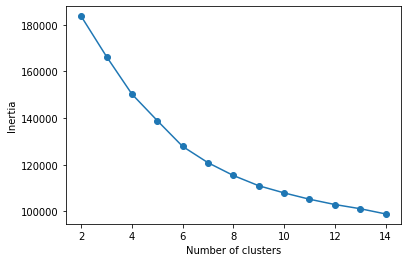

In [5]:
clusters_range = [2,3,4,5,6,7,8,9,10,11,12,13,14]
inertias =[]

for c in clusters_range:
    kmeans = k_means.pipeline(number_clusters=c).fit(X)
    inertias.append(kmeans['kmeans'].inertia_)

plt.figure()
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.plot(clusters_range,inertias, marker='o')

Based on the 'elbow' method, we can conclude that 7 or 8 will the optimal amount of clusters. We will therefore choose 7 clusters as the optimal amount. 

# Evaluation the segmentations (clusters)

In order to evaluate if 7 clusters is indeed good, we will also evaluate the clusters with a silhouette score.

In [38]:
from sklearn.cluster import KMeans
from sklearn.pipeline import make_pipeline, make_union
from sklearn.preprocessing import StandardScaler
from sklearn.impute import KNNImputer, SimpleImputer
from category_encoders import HashingEncoder

from navara.transformers.dtype_selector import DTypeSelector
from navara.transformers.correlation_filter import CorrFilterHighTotalCorrelation

from matplotlib import cm
from sklearn.metrics import silhouette_samples

In [45]:
clst = k_means.pipeline(number_clusters=7)
fitted_model = clst.fit(X)

In [46]:
fitted_model

Pipeline(steps=[('featureunion',
                 FeatureUnion(transformer_list=[('pipeline-1',
                                                 Pipeline(steps=[('dtypeselector',
                                                                  DTypeSelector(dtypes='number')),
                                                                 ('corrfilterhightotalcorrelation',
                                                                  CorrFilterHighTotalCorrelation()),
                                                                 ('knnimputer',
                                                                  KNNImputer()),
                                                                 ('standardscaler',
                                                                  StandardScaler())])),
                                                ('pipeline-2',
                                                 Pipeline(steps=[('dtypeselector',
                                          

In [47]:
y_km = fitted_model.predict(X)

In [48]:
numerical_pipeline = make_pipeline(
    DTypeSelector('number'),
    CorrFilterHighTotalCorrelation(),
    KNNImputer(n_neighbors=5),
    StandardScaler()
)

object_pipeline = make_pipeline(
    DTypeSelector('object'),
    SimpleImputer(strategy='most_frequent'),
    HashingEncoder(n_components=48)
)

pipeline = make_pipeline(
    make_union(
        numerical_pipeline,
        object_pipeline
    )
)

In [49]:
X_transformed = pipeline.fit_transform(X)

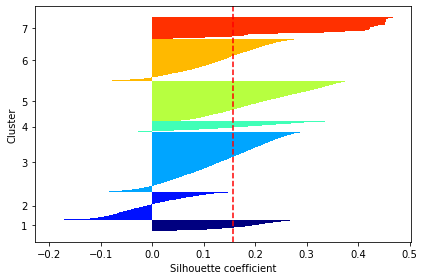

In [50]:
cluster_labels = np.unique(y_km)
n_clusters = cluster_labels.shape[0]
silhouette_vals = silhouette_samples(X_transformed, y_km, metric='euclidean')
y_ax_lower, y_ax_upper = 0, 0
yticks = []
for i, c in enumerate(cluster_labels):
    c_silhouette_vals = silhouette_vals[y_km == c]
    c_silhouette_vals.sort()
    y_ax_upper += len(c_silhouette_vals)
    color = cm.jet(float(i) / n_clusters)
    plt.barh(range(y_ax_lower, y_ax_upper), c_silhouette_vals, height=1.0, 
             edgecolor='none', color=color)

    yticks.append((y_ax_lower + y_ax_upper) / 2.)
    y_ax_lower += len(c_silhouette_vals)
    
silhouette_avg = np.mean(silhouette_vals)
plt.axvline(silhouette_avg, color="red", linestyle="--") 

plt.yticks(yticks, cluster_labels + 1)
plt.ylabel('Cluster')
plt.xlabel('Silhouette coefficient')

plt.tight_layout()
plt.show()